# Описание проекта
Область - многоклассовая классификация.
</br>В данном проекте создается модель компьютерного зрения, по фото дерева определяющая принадлежность к одному из 41 наиболее распространенному виду в г.Минске и окрестностях.
</br>Для этой задачи берется датасет айнат21.
</br>Для построения модели будем использовать фреймворк PyTorch, как наиболее удобный и современный для глубокого обучения нейросетей.
В модели будет предусмотрено отнесение дерева к классу 'OTHER', если оно не определено как наиболее часто встречающееся. А также защита, позволяющая выявлять НЕ РАСТЕНИЯ. Во избежание поломки модели.
</br> Второй частью проекта будет применение его в реальности, через заливку на сервер и доступ по API.

Импорт рабочих модулей:

In [1]:
import os
import random
import json
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torchvision as tv
import timm
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook as tqdm  
import seaborn as sns
import time
from time import sleep
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from IPython.display import display
SEED = 88888

In [2]:
print(torch.__version__)

2.1.2+cu121


In [3]:
torch.cuda.is_available()

True

Проверка условия и выбор устройства выполнения модели в зависимости от условия,
при доступности видеокарты, модель будет выполняться на CUDA: 

In [4]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda', index=0)

Загрузим данные:

In [5]:
img_path = 'data/kb'
plant_list = os.listdir(img_path) 
len(plant_list)
display(plant_list[:15])

['Abies_alba',
 'Acer_campestre',
 'Acer_ginnala',
 'Acer_platanoides',
 'Acer_pseudoplatanus',
 'Acer_saccharinum',
 'Aesculus_hippocastanum',
 'Alnus_glutinosa',
 'Alnus_incana',
 'Betula_pendula',
 'Betula_pubescens',
 'Caragana_arborescens',
 'Carpinus_betulus',
 'Fraxinus_excelsior',
 'Fraxinus_pennsylvanica']

Объединяем путь к картинке для каждого вида из 'plant_list' с самой картинкой и создаем датафрейм:

In [6]:
# список для пути
paths = []

# список для хранения классов растений
labels_list = []

for plant in plant_list:
    plant_path = os.path.join(img_path, plant)
    items = os.listdir(plant_path)
    for item in items:
        paths.append(os.path.join(plant_path, item))
        labels_list.append(plant)
        
df  = pd.DataFrame()
df['tree_types'] = labels_list
df['file_paths'] = paths
df.shape, df.head(3)

((10246, 2),
    tree_types                                         file_paths
 0  Abies_alba  data/kb\Abies_alba\029f52df-2cc8-4a79-ac85-b6e...
 1  Abies_alba  data/kb\Abies_alba\02b7ab01-807d-4207-9de6-895...
 2  Abies_alba  data/kb\Abies_alba\0319318b-7d8b-476a-b9eb-d47...)

Проверим, что лежит в датафрейме `df`:

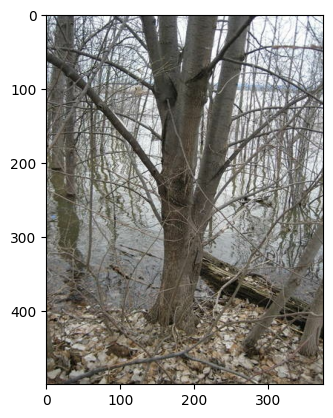

In [7]:
rnd_df = df.iloc[random.randint(0, df.shape[0] - 1)]
img_df = rnd_df ['file_paths']
img_df = Image.open(img_df )
plt.imshow(img_df)

Создаем датафрейм 'other' для остальных растений, которые не входит в 41 определяемый моделью класс:

In [8]:
display(os.listdir("data/imagenet_tiny")[:15])

['val_0.JPEG',
 'val_1.JPEG',
 'val_10.JPEG',
 'val_100.JPEG',
 'val_1000.JPEG',
 'val_1001.JPEG',
 'val_1002.JPEG',
 'val_1003.JPEG',
 'val_1004.JPEG',
 'val_1005.JPEG',
 'val_1006.JPEG',
 'val_1007.JPEG',
 'val_1008.JPEG',
 'val_1009.JPEG',
 'val_101.JPEG']

In [9]:
display(os.listdir("data/val")[:15])

['00000_Animalia_Annelida_Clitellata_Haplotaxida_Lumbricidae_Lumbricus_terrestris',
 '00001_Animalia_Annelida_Polychaeta_Sabellida_Sabellidae_Sabella_spallanzanii',
 '00002_Animalia_Annelida_Polychaeta_Sabellida_Serpulidae_Serpula_columbiana',
 '00003_Animalia_Annelida_Polychaeta_Sabellida_Serpulidae_Spirobranchus_cariniferus',
 '00004_Animalia_Arthropoda_Arachnida_Araneae_Agelenidae_Eratigena_duellica',
 '00005_Animalia_Arthropoda_Arachnida_Araneae_Antrodiaetidae_Atypoides_riversi',
 '00006_Animalia_Arthropoda_Arachnida_Araneae_Araneidae_Aculepeira_ceropegia',
 '00007_Animalia_Arthropoda_Arachnida_Araneae_Araneidae_Agalenatea_redii',
 '00008_Animalia_Arthropoda_Arachnida_Araneae_Araneidae_Araneus_bicentenarius',
 '00009_Animalia_Arthropoda_Arachnida_Araneae_Araneidae_Araneus_diadematus',
 '00010_Animalia_Arthropoda_Arachnida_Araneae_Araneidae_Araneus_marmoreus',
 '00011_Animalia_Arthropoda_Arachnida_Araneae_Araneidae_Araneus_quadratus',
 '00012_Animalia_Arthropoda_Arachnida_Araneae_Ar

In [10]:
paths = []
labels_list = []  # целевая метка
for plant in os.listdir('data/val'):
    if plant not in plant_list and 'Plantae' in plant: # доп фильтр, что подтягиваем только растения 
        plant_path = os.path.join('data/val', plant)
        items = os.listdir(plant_path)
        for item in items:
            paths.append(os.path.join(plant_path, item))
            labels_list.append('Other')
        
df_other = pd.DataFrame()        
df_other['file_paths'] = paths
df_other['tree_types'] = labels_list
df_other = df_other.sample(frac=0.1)
df_other.shape, df_other.head(3)


((4271, 2),
                                               file_paths tree_types
 4068   data/val\06135_Plantae_Tracheophyta_Liliopsida...      Other
 18442  data/val\07573_Plantae_Tracheophyta_Magnoliops...      Other
 19133  data/val\07642_Plantae_Tracheophyta_Magnoliops...      Other)

Проверим, что лежит в датафрейме `other`:

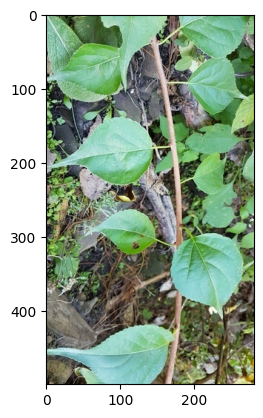

In [11]:
# рандомное фото из датасета other:

rnd_img_other = df_other.iloc[random.randint(0, df_other.shape[0]-1)]
im_other = rnd_img_other['file_paths'] 
im_other = Image.open(im_other)
plt.imshow(im_other)

Создадим защиту, на случай попадания фотографии, вообще не соответствующей растениям. Для этого будем использовать часть датасета ImageNet50:

In [12]:
paths = []
labels_list = []
for pic in os.listdir('data/imagenet_tiny'):
    pic_path = os.path.join('data/imagenet_tiny', pic)
    paths.append(pic_path)
    labels_list.append('not_plant')
        
df_not_plant = pd.DataFrame()        
df_not_plant['file_paths'] = paths
df_not_plant['tree_types'] = labels_list
df_not_plant.shape, df_not_plant.head(5)


((10000, 2),
                          file_paths tree_types
 0     data/imagenet_tiny\val_0.JPEG  not_plant
 1     data/imagenet_tiny\val_1.JPEG  not_plant
 2    data/imagenet_tiny\val_10.JPEG  not_plant
 3   data/imagenet_tiny\val_100.JPEG  not_plant
 4  data/imagenet_tiny\val_1000.JPEG  not_plant)

In [13]:
pic_path

'data/imagenet_tiny\\val_9999.JPEG'

Проверим, что находится в датафрейме `df_not_plant`:

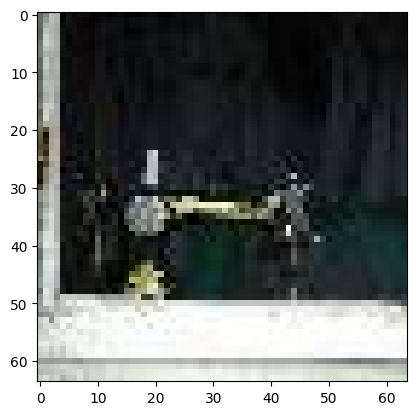

In [14]:
rnd = df_not_plant.iloc[random.randint(0, df_not_plant.shape[0]-1)]
im = rnd['file_paths']
im = Image.open(im)
plt.imshow(im)

# Кодирование данных

Преобразуем метки классов (названия растений в столбце 'tree_types') в числовые значения:

Объединение датасетов:

In [15]:
df_full = pd.concat([df, df_other, df_not_plant])

df_full.sample(20)

,tree_types,file_paths
360,not_plant,data/imagenet_tiny\val_1321.JPEG
2109,not_plant,data/imagenet_tiny\val_2897.JPEG
7323,not_plant,data/imagenet_tiny\val_759.JPEG
733,not_plant,data/imagenet_tiny\val_1658.JPEG
9080,Salix_babylonica,data/kb\Salix_babylonica\ba9ce9de-7c17-4455-93...
22415,Other,data/val\07970_Plantae_Tracheophyta_Magnoliops...
18447,Other,data/val\07573_Plantae_Tracheophyta_Magnoliops...
5153,not_plant,data/imagenet_tiny\val_5636.JPEG
9986,not_plant,data/imagenet_tiny\val_9987.JPEG
9153,Tilia_cordata,data/kb\Tilia_cordata\0a0f0ce4-6532-4d7d-a44f-...


In [16]:
# Сортировка в лексикографическом порядке:

df_full = df_full.sort_values('tree_types')

In [17]:
# Импорт LabelEncoder():

label_encoder = LabelEncoder()

In [18]:
# Добавление столбца 'labels' с метками клаcса в df_full:

df_full['labels'] = label_encoder.fit_transform(df_full['tree_types'])
df_full.sample(3)

,tree_types,file_paths,labels
9112,not_plant,data/imagenet_tiny\val_92.JPEG,42
23762,Other,data/val\08105_Plantae_Tracheophyta_Magnoliops...,21
9152,Tilia_cordata,data/kb\Tilia_cordata\092f8115-c3d9-4716-9218-...,37


Создание словаря с метками классов для дальнейшнго использования с API:

In [19]:
# Словарь, в котором каждому уникальному значению из столбца 'tree_types' в df_full сопоставляется соответствующий числовой индекс.

label_dict = {i: class_name for i, class_name in enumerate(df_full['tree_types'].unique())}

In [20]:
# Открываем файл в режиме записи
with open ('data/label_dict.json', 'w') as f:
    # Сериализуем объект и записываем его в файл
    json.dump(label_dict, f)

In [21]:
# десериализация объекта label_dict.json

with open('data/label_dict.json', 'r') as f:
    label_dict = json.load(f)
label_dict

{'0': 'Abies_alba',
 '1': 'Acer_campestre',
 '2': 'Acer_ginnala',
 '3': 'Acer_platanoides',
 '4': 'Acer_pseudoplatanus',
 '5': 'Acer_saccharinum',
 '6': 'Aesculus_hippocastanum',
 '7': 'Alnus_glutinosa',
 '8': 'Alnus_incana',
 '9': 'Betula_pendula',
 '10': 'Betula_pubescens',
 '11': 'Caragana_arborescens',
 '12': 'Carpinus_betulus',
 '13': 'Fraxinus_excelsior',
 '14': 'Fraxinus_pennsylvanica',
 '15': 'Juglans_mandshurica',
 '16': 'Juglans_regia',
 '17': 'Larix_sibirica',
 '18': 'Malus_domestica',
 '19': 'Malus_prunifolia',
 '20': 'Malus_toringo',
 '21': 'Other',
 '22': 'Picea_abies',
 '23': 'Pinus_sylvestris',
 '24': 'Populus_alba',
 '25': 'Populus_berolinensis',
 '26': 'Populus_nigra',
 '27': 'Populus_tremula',
 '28': 'Prunus_avium',
 '29': 'Prunus_cerasifera',
 '30': 'Prunus_domestica',
 '31': 'Pseudotsuga_menziesii',
 '32': 'Pyrus_communis',
 '33': 'Quercus_robur',
 '34': 'Quercus_rubra',
 '35': 'Salix_alba',
 '36': 'Salix_babylonica',
 '37': 'Tilia_cordata',
 '38': 'Tilia_platyphyl

In [22]:
# сохраним равномерное распределение классов в тестовой и трейновой выборках, используя нормализацию stratify=df_full['tree_types']

df_train, df_test = train_test_split(df_full, test_size = 0.1, shuffle=True, random_state=SEED, stratify=df_full['tree_types'])
df_train.shape, df_test.shape

((22065, 3), (2452, 3))

# Подготовка торч-датасета

In [23]:
# приведем все изображения к одному размеру 336х336 px:

img_size = (336, 336)

In [24]:
class TorchDataset(torch.utils.data.Dataset):
     #ручной класс, преобразующий изображение в тензор
   
    def __init__(self, dataframe, img_size):
        """В методе __init__ инициализируются атрибуты класса: dataframe, resize и to_tensor.
          dataframe - датафрейм, передаваемый в класс.
          resize - поменять размер входящего изображения до заданного в img_size с использованием сглаживания (antialias=True).
          to_tensor - преобразование изображения в тензор.""" 
      
        self.dataframe = dataframe
        self.resize = tv.transforms.Resize((img_size[0], img_size[1]), antialias=True)
        self.to_tensor = tv.transforms.ToTensor()

    def __len__(self):
        """Возвращает длину датафрейма."""
        return len(self.dataframe)

    def __getitem__(self, idx):
        """Получение изображения и его метки по заданному индексу idx, а также преобразование изображения в тензор."""
       
        image_path = self.dataframe.iloc[idx]['file_paths']
        image = Image.open(image_path)
        image = image.convert("RGB")
        image = self.resize(image)
        image = self.to_tensor(image)
        image = image[:3, :, :]
        
        label = self.dataframe.iloc[idx]['labels']
        label = torch.tensor(label, dtype=torch.long) 
        return image, label # возвращает само изображние в виде тензора и метку класса (label) в виде тензора

Создаем torch_датасеты для модели:

In [25]:
train_dataset = TorchDataset(df_train, img_size)
test_dataset = TorchDataset(df_test, img_size)

Проверим работу ручного класса:

In [26]:
test_dataset.__getitem__(36)

(tensor([[[0.2706, 0.2588, 0.2902,  ..., 0.1804, 0.1922, 0.2039],
          [0.2745, 0.2784, 0.3176,  ..., 0.1725, 0.1843, 0.2000],
          [0.3059, 0.3255, 0.3490,  ..., 0.1647, 0.1765, 0.1922],
          ...,
          [0.4314, 0.4431, 0.4588,  ..., 0.4275, 0.4235, 0.4157],
          [0.4235, 0.4353, 0.4549,  ..., 0.4314, 0.4275, 0.4196],
          [0.4196, 0.4314, 0.4510,  ..., 0.4275, 0.4196, 0.4118]],
 
         [[0.3647, 0.3529, 0.3804,  ..., 0.1686, 0.1843, 0.1961],
          [0.3686, 0.3686, 0.4078,  ..., 0.1608, 0.1765, 0.1922],
          [0.4000, 0.4157, 0.4392,  ..., 0.1569, 0.1686, 0.1804],
          ...,
          [0.3725, 0.3843, 0.4000,  ..., 0.3647, 0.3608, 0.3529],
          [0.3647, 0.3765, 0.3961,  ..., 0.3686, 0.3647, 0.3569],
          [0.3608, 0.3725, 0.3922,  ..., 0.3725, 0.3647, 0.3569]],
 
         [[0.1725, 0.1686, 0.2157,  ..., 0.0941, 0.1020, 0.1137],
          [0.1725, 0.1843, 0.2392,  ..., 0.0902, 0.0941, 0.1098],
          [0.2000, 0.2275, 0.2627,  ...,

In [27]:
len(train_dataset)

22065

# Создание Torch-загрузчика данных

Создаем загрузчик данных Torch data loader:

In [28]:
batch_size = 128
# тренировочный набор данных:
train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# тестовый набор данных:
test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

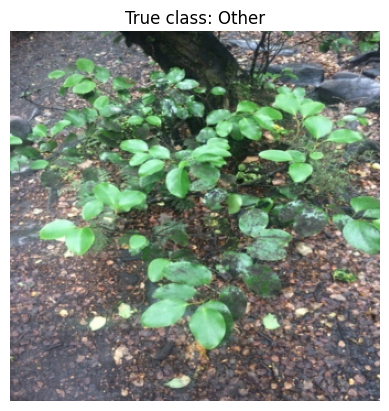

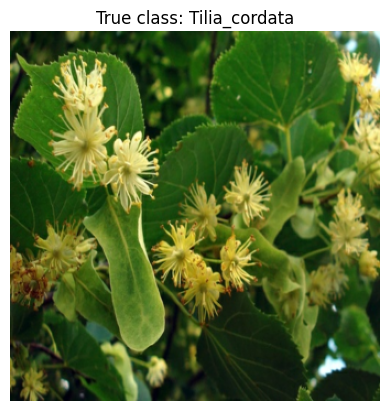

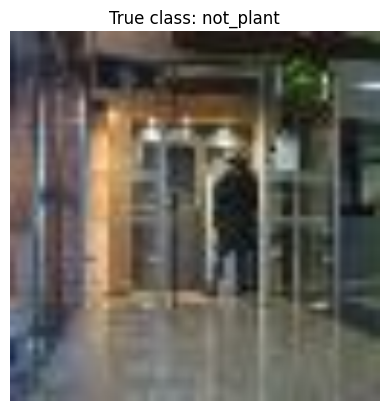

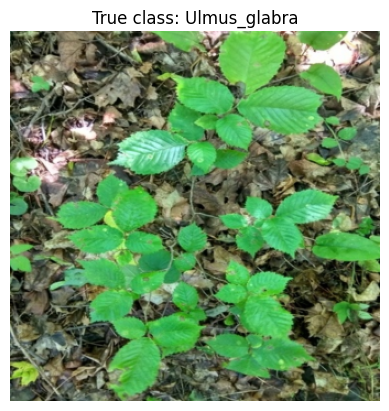

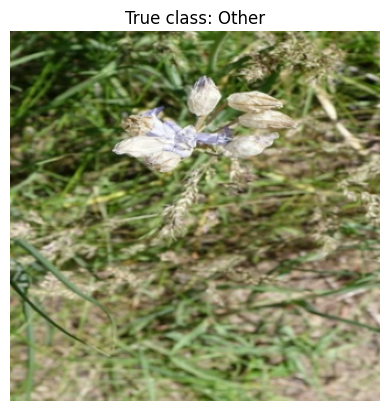

In [29]:
# Выведем первые 5 изображений из тренировочного набора данных, их метки и соответствующие классы
# в виде графиков с использованием библиотеки Matplotlib.

counter = 0
for batch_images, batch_labels in train:
    for image, label in zip(batch_images, batch_labels):
        image_np = np.array(image)
        image_np = np.transpose(image_np, (1, 2, 0))
        plt.imshow(image_np)
        plt.title(f"True class: {label_dict[str(label.item())]}")
        plt.axis('off')
        plt.show()
        counter += 1
        if counter == 5:
            break
    if counter == 5:
        break

In [30]:
# Кол-во нейронов на выходе для модели(= кол-ву уникальных меток классов):

class_count = len(df_full['tree_types'].unique())
class_count

43

# Vision Transformer

Представление работы архитектуры модели ViT:

![TP](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/model_doc/vit_architecture.jpg)

In [31]:
# создание собственной модели на основании предобученной:

vit = timm.create_model("hf_hub:timm/vit_large_patch14_clip_336.laion2b_ft_augreg_inat21", pretrained=True)

In [32]:
# используем веса предобученной модели без изменений:

for param in vit.parameters():
    param.requires_grad = False

In [33]:
# кол-во выходных признаков последнего слоя модели:

vit_out_features = list(vit.modules())[-1].out_features
vit_out_features

10000

# Модель классификации

In [34]:
hidden = 16 # кол-во скрытых слоев
model = torch.nn.Sequential(
    vit,
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.2, inplace=False),
    torch.nn.Linear(vit_out_features, hidden*class_count), # первый полносвязный слой, выполняет линейное преобраз-ие входных данных
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.2, inplace=False),
    torch.nn.Linear(hidden*class_count, class_count) # второй полносвязный слой
)

In [35]:
# перенапраление модели на device:

model = model.to(device)

In [36]:
model

Sequential(
  (0): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1024, out_features=3072, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=1024, out_features=4

In [37]:
# кол-во параметров в модели:

num_params = sum(torch.numel(param) for param in model.parameters())
print(f"Number of parameters: {num_params}")

Number of parameters: 320667771


In [38]:
# кол-во параметров участвующих в обучении:

num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_trainable_params}")

Number of trainable parameters: 6910315


In [39]:
epochs =  4
lr = 0.0001
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr) # оптимизатор для обновления параметров модели

# Обучение модели

In [40]:
def train_model(model, optimizer, n_epochs=10):
     for ep in range(n_epochs):
      print(f'Epoch {ep} started')
      train_iters, train_passed  = 0, 0 # переменные для отслеживания статистики обучения модели
      train_loss, train_acc = 0., 0. # --//--

      print('Training model')
      model.train()
      for X, y in tqdm(train):
          # считаем сколько предсказанных таргетов батча совпадает с фактическими таргетами
          X, y = X.to(device), y.to(device)
          optimizer.zero_grad() # сброс градиентов
          y_pred = model(X)
          l = loss(y_pred, y)
          l.backward() # вычисление градиентов
          optimizer.step() # шаг градиентного спуска
          train_loss += l.item()
          train_acc += (y_pred.argmax(dim=1) == y).sum().item() # увеличивается на кол-во правильных предсказаний 
          train_iters += 1
          train_passed += len(X)

      print('Evaluating model')
      model.eval()
      test_iters, test_passed  = 0, 0
      test_loss, test_acc = 0., 0.
      for X, y in tqdm(test):
          # подсчет совпадений предсказанных таргетов батча и фактических
          X, y = X.to(device), y.to(device)
          y_pred = model(X)
          l = loss(y_pred, y) # вычисление ошибки между предсказанием и реальным значением
          test_loss += l.item()
          test_acc += (y_pred.argmax(dim=1) == y).sum().item()
          test_iters += 1
          test_passed += len(X)
          
      print("ep: {}, train_loss: {}, train_acc: {}, test_loss: {}, test_acc: {}".format(
          ep, train_loss / train_iters, train_acc / train_passed,
          test_loss / test_iters, test_acc / test_passed)
      )
      torch.cuda.empty_cache()

In [41]:
%%time
train_model(model, optimizer, epochs)

Epoch 0 started
Training model


  0%|          | 0/173 [00:00<?, ?it/s]

Evaluating model


  0%|          | 0/20 [00:00<?, ?it/s]

ep: 0, train_loss: 0.7100167901960411, train_acc: 0.8580557443915704, test_loss: 0.1610768236219883, test_acc: 0.9698205546492659
Epoch 1 started
Training model


  0%|          | 0/173 [00:00<?, ?it/s]

Evaluating model


  0%|          | 0/20 [00:00<?, ?it/s]

ep: 1, train_loss: 0.10792355496716292, train_acc: 0.9796057104010877, test_loss: 0.10293665928766131, test_acc: 0.9738988580750407
Epoch 2 started
Training model


  0%|          | 0/173 [00:00<?, ?it/s]

Evaluating model


  0%|          | 0/20 [00:00<?, ?it/s]

ep: 2, train_loss: 0.06004389412055126, train_acc: 0.9881713120326309, test_loss: 0.08671900490298867, test_acc: 0.9759380097879282
Epoch 3 started
Training model


  0%|          | 0/173 [00:00<?, ?it/s]

Evaluating model


  0%|          | 0/20 [00:00<?, ?it/s]

ep: 3, train_loss: 0.03801319650185935, train_acc: 0.993111262179923, test_loss: 0.07747511519119143, test_acc: 0.9771615008156607
CPU times: total: 1h 50min 3s
Wall time: 53min 14s


# Проверка на тестовых данных

True label:
not_plant
------
Predicted label:
not_plant
Probability: 100.0%
------
not_plant 100.0%
Other 0.0%
Juglans_mandshurica 0.0%


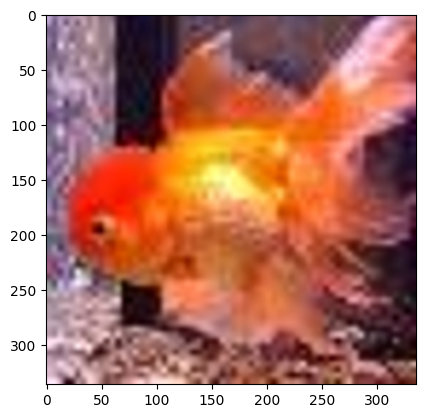

In [42]:
# выбор рандомного изображения из тестовой выборки и вывод изображения на экран:
rnd = df_test.iloc[random.randint(0, df_test.shape[0]-1)]
im = rnd['file_paths']
label = rnd['tree_types']


image = Image.open(im)
image = image.resize((img_size[0], img_size[1]))
plt.imshow(image)

# преобразование в тензор:
image = np.array(image) 
image = image[:, :, :3] # оставляем лишь первые три канала изображения RGB
image = torch.tensor(image).float() # преобразование массива numpy в тензор размерности float(нужно для модели PyTorch)
#добавление батч - измерения:
image = image.unsqueeze(0) 

image = image.permute(0, 3, 1, 2) # порядок размерности тензора приводит к требуемому в PyTorch: batch_size, channels, height, width.
image = image / 255.0 # нормализуем значения пикселей изображения в вид в диапазоне от 0 до 1.

# инференс модели:

with torch.no_grad(): # сделаем предсказания модели на входном изображении без вычисления и сохранения градиентов.
    output = model(image.to(device))
    probabilities = torch.nn.functional.softmax(output, dim=1) # применяем функцию softmax к выходному тензору. 
    predicted_class = torch.argmax(probabilities, dim=1) # находим индекс класса с наибольшей вероятностью в каждом наблюдении.
    top_probs, top_classes = torch.topk(probabilities, k=3, dim=1) # топ-3 вероятностей и классов.

print(f'True label:\n{label}')
print('------')
print(f'Predicted label:\n{label_dict[str(predicted_class.item())]}')
print(f'Probability: {round(probabilities[0][predicted_class].item()*100, 2)}%')
print('------')
possible = [label_dict[str(pred.item())] for pred in top_classes[0]]
probs = [prob.item() for prob in top_probs[0]]
for pos, prob in zip(possible, probs):
    print(f'{pos} {round(prob*100, 2)}%')




# Оценка модели

Для оценки получившейся модели рассчитаем метрику `top-k` и составим отчет:

In [43]:
%%time

total_samples = 0
correct_topk = 0

true_labels = []
predicted_labels = []

top_k = 2

with torch.no_grad(): # уходим от вычисления и сохранения градиента для увеличения скорости и уменьшения задействуемых ресурсов.
    for images, labels in test:
        
        true_labels.extend(labels) # добавляем метки labels в конец списка true_labels
    
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = outputs.topk(top_k, dim=1) # top-k предсказанных классов и _ - соответствующие им вероятности, которые дальше не исп.

        # top_k accuracy
        total_samples += labels.size(0)
        correct_topk += sum([labels[i] in predicted[i] for i in range(labels.size(0))])

        # предсказания для очтета 
        predicted_labels.extend(predicted[:, 0].cpu().numpy())

topk_accuracy = 100.0 * correct_topk / total_samples
print(f"Top-{top_k} Accuracy: {topk_accuracy:.2f}%")

Top-2 Accuracy: 99.31%
CPU times: total: 2min 31s
Wall time: 1min 18s


In [44]:
classification_rep = classification_report(true_labels, predicted_labels, zero_division=0, output_dict=True) # отчет в виде словаря
classification_rep = pd.DataFrame(classification_rep).T
classification_rep

,precision,recall,f1-score,support
0,1.000000,0.950000,0.974359,20.000000
1,0.967742,1.000000,0.983607,30.000000
2,1.000000,1.000000,1.000000,30.000000
3,1.000000,0.966667,0.983051,30.000000
4,1.000000,0.966667,0.983051,30.000000
5,1.000000,0.966667,0.983051,30.000000
6,1.000000,1.000000,1.000000,30.000000
7,1.000000,1.000000,1.000000,30.000000
8,1.000000,0.933333,0.965517,30.000000
9,1.000000,1.000000,1.000000,30.000000


# Наиболее распознаваемые моделью виды деревьев

In [45]:
top_f1 = list(classification_rep.sort_values('f1-score', ascending=False).head(10).index)

In [46]:
# 10 наиболее распознаваемых видов деревьев:

[' '.join(label_dict[label].split('_')) for label in top_f1][:10]

['Caragana arborescens',
 'Ulmus minor',
 'Populus alba',
 'Populus tremula',
 'Pseudotsuga menziesii',
 'Pyrus communis',
 'Larix sibirica',
 'Quercus rubra',
 'Ulmus glabra',
 'Fraxinus excelsior']

# Cохранение модели

In [47]:
torch.save(model, 'models/plants_vit_33.pth')